In [115]:
import pandas as pd
import numpy as np

import seaborn as sb
sb.set(context="paper", font="monospace")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

# Models 
from sklearn.ensemble import GradientBoostingClassifier
from rgf.sklearn import RGFRegressor

# Validation and splitting packages
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [76]:
train = pd.read_csv('~/Desktop/Donors/train.csv')
resources = pd.read_csv('~/Desktop/Donors/resources.csv')
test = pd.read_csv('~/Desktop/Donors/test.csv')

/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
print('There are {} records in the training set'.format(train.shape[0]))
print('There are {} records in the test set'.format(test.shape[0]))

There are 182080 records in the training set
There are 78035 records in the test set


In [90]:
resources['description'] = resources['description'].astype(str)

In [91]:
resources['Item'] = resources[['id','description']].groupby(['id'])['description'].transform(lambda x: ','.join(x))

In [92]:
resources.head()

,id,description,quantity,price,Item
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00,LC652 - Lakeshore Double-Space Mobile Drying Rack
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95,"Bouncy Bands for Desks (Blue support pipes),Co..."
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45,"Bouncy Bands for Desks (Blue support pipes),Co..."
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59,"Bouncy Bands for Desks (Blue support pipes),Co..."
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95,"Bouncy Bands for Desks (Blue support pipes),Co..."


In [95]:
resources['Item_Count'] = 1
Count = resources[['id','description','Item_Count']].groupby(['id'],as_index=False)['Item_Count'].sum()

In [96]:
resources = resources.merge(Count, on =['id'])

In [97]:
resources.drop(['Item_Count_x'],axis=1,inplace=True)
resources.rename(columns={'Item_Count_y':'Item_Count'},inplace=True)

In [99]:
resources = resources.groupby(['id','Item','Item_Count'],as_index=False)['quantity','price'].sum()

In [100]:
resources.head()

,id,Item,Item_Count,quantity,price
0,p000001,"Cap Barbell 300 Pound Olympic Set, Grey,Cap Ba...",4,7,459.56
1,p000002,"10 Sony Headphones (BUY 9 GET 1 FREE),Belkin 6...",14,21,515.89
2,p000003,EE820X - Phonemic Awareness Instant Learning C...,4,4,298.97
3,p000004,A Bad Case of the Giggles Poems That Will Make...,95,98,1113.69
4,p000005,"Fitbit Zip Wireless Activity Tracker, Lime,Fit...",4,8,485.99


In [101]:
train = train.merge(resources, on = ['id'])

In [102]:
train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,Item,Item_Count,quantity,price
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,Apple - iPod nano� 16GB MP3 Player (8th Genera...,2,6,299.98
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,Reebok Girls' Fashion Dance Graphic T-Shirt - ...,1,20,20.00
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,3doodler Start Full Edu Bundle,1,1,469.99
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,"BALL PG 4'' POLY SET OF 6 COLORS,BALL PLAYGROU...",5,5,684.47
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,Crown Berkey Water Filter With 2 Black and 2 P...,1,2,355.50


In [74]:
#resources[resources.id=='p036502'].to_csv('~/Desktop/test.csv')

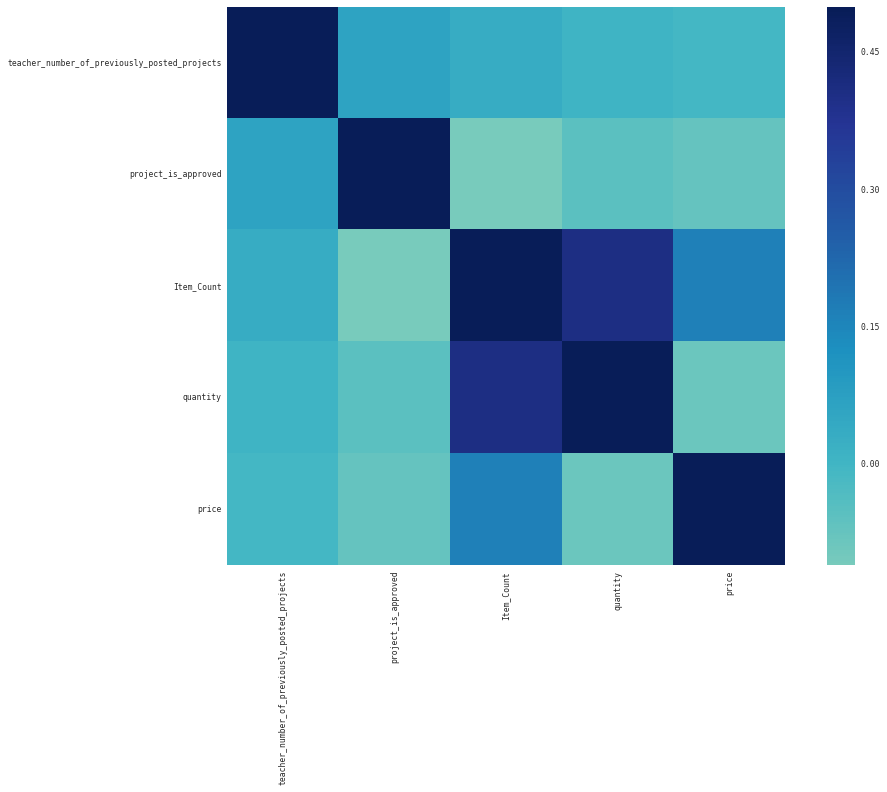

In [103]:
corrmat = train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=0.5, square=True,center=0,cmap="YlGnBu")

In [104]:
def concat_all_strings(df):
    """ run time: 1.3416s """
    return pd.Series([', '.join(row.astype(str)) for row in df.values], index=df.index)

In [105]:
train_x_text =  train.copy().drop(['id','teacher_id'],axis=1)
train_x_text.replace(np.nan, '', regex=True,inplace=True)
columns = train_x_text.select_dtypes(include=['object']).columns
train_x_text['all_text_cols'] = concat_all_strings(train_x_text[columns])
train_x_text.drop(columns=columns,axis=1,inplace=True)
no_nulls = train_x_text[~train_x_text.isnull().any(axis=1)].copy()

In [106]:
n_features = 20
tfidf = TfidfVectorizer(max_features=n_features)

no_nulls['Word_Keys_len'] = no_nulls['all_text_cols'].map(len) #Lenth of Description
no_nulls['Word_Keys_wc'] = no_nulls['all_text_cols'].map(lambda x: len(str(x).split(' ')))

In [107]:
txtFeatures = pd.DataFrame(tfidf.fit_transform(no_nulls['all_text_cols']).toarray())
cols = txtFeatures.columns
for i in range(n_features):
    no_nulls['Word_Key_tfidf_' + str(i)] = txtFeatures[cols[i]]
no_nulls.head()

,teacher_number_of_previously_posted_projects,project_is_approved,Item_Count,quantity,price,all_text_cols,Word_Keys_len,Word_Keys_wc,Word_Key_tfidf_0,Word_Key_tfidf_1,...,Word_Key_tfidf_10,Word_Key_tfidf_11,Word_Key_tfidf_12,Word_Key_tfidf_13,Word_Key_tfidf_14,Word_Key_tfidf_15,Word_Key_tfidf_16,Word_Key_tfidf_17,Word_Key_tfidf_18,Word_Key_tfidf_19
0,26,1,2,6,299.98,"Ms., NV, 2016-11-18 14:45:59, Grades PreK-2, L...",2160,376,0.309011,0.173920,...,0.096561,0.252753,0.094858,0.393759,0.303282,0.137946,0.243357,0.561699,0.031378,0.152320
1,1,0,1,20,20.00,"Mrs., GA, 2017-04-26 15:57:28, Grades 3-5, Mus...",1519,245,0.320796,0.110338,...,0.306300,0.267252,0.060180,0.267652,0.057722,0.131274,0.057896,0.427623,0.059720,0.173943
2,5,1,1,1,469.99,"Ms., UT, 2017-01-01 22:57:44, Grades 3-5, Math...",1675,297,0.215180,0.185028,...,0.164365,0.501941,0.080734,0.287252,0.077437,0.132082,0.116505,0.466109,0.200292,0.000000
3,16,0,5,5,684.47,"Mr., NC, 2016-08-12 15:42:11, Grades 3-5, Heal...",2953,492,0.216086,0.267562,...,0.272344,0.280830,0.048644,0.475961,0.093315,0.053055,0.397784,0.259239,0.096545,0.164033
4,42,1,1,2,355.50,"Mr., CA, 2016-08-06 09:09:11, Grades 6-8, Heal...",1281,239,0.325431,0.191883,...,0.000000,0.325336,0.209312,0.418915,0.100382,0.000000,0.050342,0.232393,0.000000,0.151248


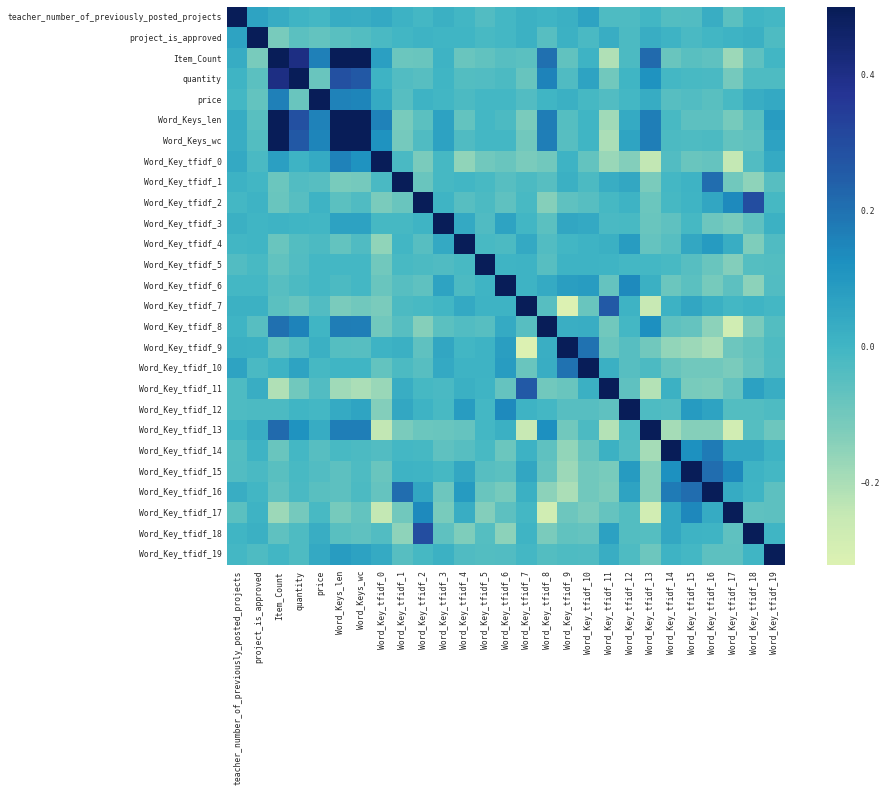

In [110]:
corrmat = no_nulls.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sb.heatmap(corrmat, vmax=0.5, square=True,center=0,cmap="YlGnBu")

In [117]:
X_train_text_data, X_test_text_data, y_train_text_data, y_test_text_data= train_test_split(no_nulls.drop(['all_text_cols','project_is_approved'],axis=1), no_nulls[['project_is_approved']], train_size=.75, random_state=1)

# Show the results of the split
print ("Training set has {} samples.".format(X_train_text_data.shape[0]))
print ("Testing set has {} samples.".format(X_test_text_data.shape[0]))


Training set has 136560 samples.
Testing set has 45520 samples.


In [ ]:
gradient_booster =  GradientBoostingClassifier(random_state=42)

params = [{'max_depth':[2,3,4,5,6,7,8,9]},{'n_estimators':[10,25,50,75,100,125,150,200]},
          {'learning_rate':[.001,.01,.095,.1,.105,.15,.2,.25,.3,.4]},
          {'min_samples_split':[2,4,5,6,7,8]}]

best_GB_text = GridSearchCV(gradient_booster, params, cv=10, verbose=1)
best_GB_text.fit(X_train_text_data,y_train_text_data)

print (best_GB_text.best_params_)
best_GB_text = best_GB_text.best_estimator_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/juliacreighton/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d

In [ ]:
preds = best_GB_text.predict(X_test_text_data)
print (mean_squared_error(y_test_text_data,preds))

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_test_text_data, preds))
print()
print('Classification Report')
print(classification_report(y_test_text_data, preds))

In [ ]:
y_scores_gb = gb.decision_function(X_test_text_data)
fpr_gb, tpr_gb, _ = roc_curve(y_test_text_data, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

In [ ]:
# Look for a seasonal component - Graph the acceptance rate over time, does it spike at certain periods?
# Do projects that get submitted during specific times of the year get accepted more often? 

In [ ]:
train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])

train['projected_submitted_month'] = train['project_submitted_datetime'].month

In [ ]:
train.groupby(by=['projected_submitted_month'])